In [1]:
import os
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from PIL import Image
from inversion import NullInversion
from swapping_class import AttentionSwap, LocalBlend
from utils import text2image

In [2]:
source_image_path = 'source_image/titanic-jack-1.jpg'

source_subject_word = 'man'
source_prompt = "A photo of a man" # Add another word 'man' so the source and target prompt have the same token length. This is not a necessary step.

target_subject_word = 'sks'
target_prompt = "A photo of a sks man" # Changing the subject into the target. 'sks man' is the name used when training this example concept learning model.

concept_model_path = 'checkpoints/justin-800/' # The model that already include the new concept

# The three parameters used to change the tuning. Different concept learning model may have different parameter range.
cross_map_replace_steps = 0.6
self_output_replace_steps = 0.8
self_map_replace_steps = 0.0

assert self_output_replace_steps + self_map_replace_steps <= 1.0

In [3]:
use_second_example = False
if use_second_example:
    source_image_path = 'source_image/feifei-li.jpg'

    source_subject_word = 'woman'
    source_prompt = "A photo of a woman woman, smiling" # Add another word 'woman' so the source and target prompt have the same token length. This is not a necessary step.

    target_subject_word = 'sks'
    target_prompt = "A photo of a sks woman, smiling" # Changing the subject into the target. 'sks woman' is the name used when training this example concept learning model.

    concept_model_path = 'checkpoints/taylor-800/' # The model that already include the new concept

    # The three parameters used to change the tuning. Different concept learning model may have different parameter range.
    cross_map_replace_steps = 0.9
    self_output_replace_steps = 0.9
    self_map_replace_steps = 0.0

    assert self_output_replace_steps + self_map_replace_steps <= 1.0

In [4]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

concept_model = StableDiffusionPipeline.from_pretrained(concept_model_path, scheduler=scheduler).to(device)

try:
    concept_model.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = concept_model.tokenizer

The config attributes {'addition_embed_type': None, 'addition_embed_type_num_heads': 64, 'class_embeddings_concat': False, 'cross_attention_norm': None, 'encoder_hid_dim': None, 'mid_block_only_cross_attention': None, 'resnet_out_scale_factor': 1.0, 'resnet_skip_time_act': False, 'time_embedding_act_fn': None, 'time_embedding_dim': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/opt/conda/envs/swap/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_off

In [5]:
null_inversion = NullInversion(concept_model, ddim_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE)
x_t, uncond_embeddings = null_inversion.invert(source_image_path, source_prompt)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Original Image:


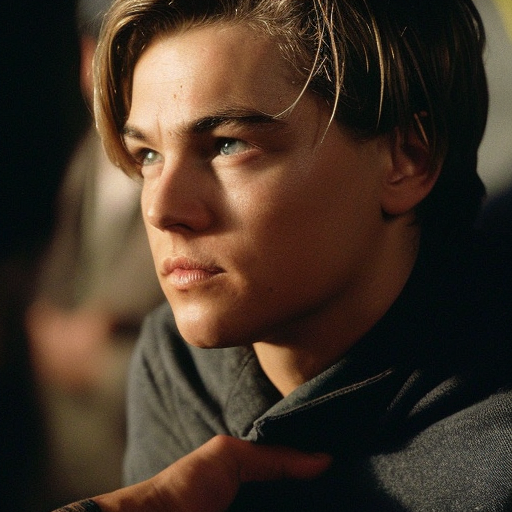


Image after subject swapping:


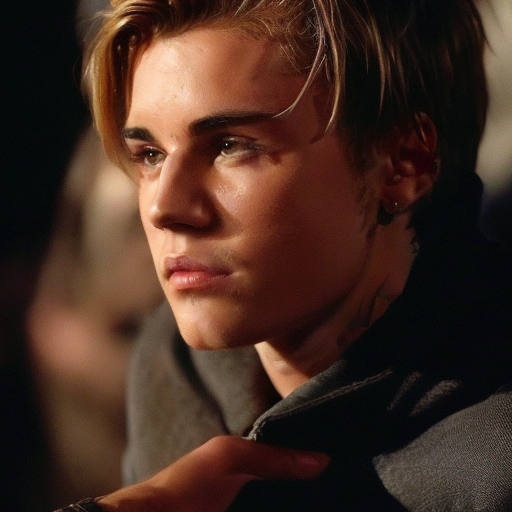

In [6]:
from swapping_class import AttentionSwap


prompts = [source_prompt, target_prompt]

controller = AttentionSwap(prompts, NUM_DDIM_STEPS, cross_map_replace_steps=cross_map_replace_steps, self_map_replace_steps=self_map_replace_steps,
                           self_output_replace_steps=self_output_replace_steps, source_subject_word=source_subject_word, target_subject_word=target_subject_word,
                           tokenizer=concept_model.tokenizer, device=device, LOW_RESOURCE=LOW_RESOURCE)

images, x_t = text2image(concept_model, prompts, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE,
                         generator=None, uncond_embeddings=uncond_embeddings)

out_dir = "./photoswap_real_output/"

os.makedirs(out_dir, exist_ok=True)
count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{count}")
os.makedirs(out_dir, exist_ok=True)

print('Original Image:')
display(Image.fromarray(images[0]))
Image.fromarray(images[0]).save(out_dir+'/source.png')
print('\nImage after subject swapping:')
display(Image.fromarray(images[1]))
Image.fromarray(images[1]).save(out_dir+'/result.png')

## Grid Search
Here we provide an example to search 'cross_map_replace_steps' and 'self_output_replace_steps'. You could search over different prompt, replace step to find the best image.


In [ ]:
for cross_map_replace_steps in [0.5,0.6, 0.7, 0.8, 0.9]:
    for self_output_replace_steps in [0.5,0.6, 0.7, 0.8, 0.9]:
        prompts = [source_prompt, target_prompt]

        controller = AttentionSwap(prompts, NUM_DDIM_STEPS, cross_map_replace_steps=cross_map_replace_steps, self_map_replace_steps=self_map_replace_steps,
                                   self_output_replace_steps=self_output_replace_steps, source_subject_word=source_subject_word, target_subject_word=target_subject_word,
                                   tokenizer=concept_model.tokenizer, device=device, LOW_RESOURCE=LOW_RESOURCE)

        images, x_t = text2image(concept_model, prompts, controller, latent=x_t, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE,
                                 generator=None, uncond_embeddings=uncond_embeddings)

        print('Original Image:')
        display(Image.fromarray(images[0]))
        print('\nImage after subject swapping:')
        display(Image.fromarray(images[1]))
        print(cross_map_replace_steps, self_output_replace_steps)